# Procesamiento de Datos de Precipitación Acumulada Diaria

In [ ]:
import os
import pandas as pd
import numpy as np
from PyEMD import CEEMDAN
from vmdpy import VMD
import multiprocessing as mp
import warnings

# Pasos del pipeline

def setup_workspace():
    WORKSPACE = os.path.abspath(os.getcwd())
    DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')
    os.makedirs(os.path.join(DATA_FOLDER, 'processing'), exist_ok=True)
    print("Workspace:", WORKSPACE)
    print("Data folder:", DATA_FOLDER)
    return DATA_FOLDER

def load_and_clean_data(data_folder):
    # Leer el archivo CSV
    df = pd.read_csv(
        os.path.join(data_folder, 'raw', 'PTPM_CON.csv'),
        usecols=['Fecha', 'CodigoEstacion', 'Valor'],
        dtype={'Fecha': str, 'CodigoEstacion': str, 'Valor': str},
    )
    # Convertir tipos y limpiar datos
    df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
    df = df.dropna(subset=['Valor', 'Fecha'])
    df['Fecha'] = df['Fecha'].dt.normalize()  
    return df

def filter_stations(df, data_folder):
    # Leer archivos de estaciones y combinarlas
    high_missing_stations = pd.read_csv(os.path.join(data_folder, 'stations_high_missing.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    rain_persistence_stations = pd.read_csv(os.path.join(data_folder, 'stations_rain_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    zero_persistence_stations = pd.read_csv(os.path.join(data_folder, 'stations_zero_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    stations_to_exclude = pd.concat([high_missing_stations, rain_persistence_stations, zero_persistence_stations]).unique()
    df = df[~df['CodigoEstacion'].isin(stations_to_exclude)]
    return df

def normalize_and_create_windows(df, data_folder):
    # Normalizar datos
    df['ValorNormalizado'] = df.groupby('CodigoEstacion')['Valor'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    windows = []
    for station_code, station_group in df.groupby('CodigoEstacion'):
        sorted_group = station_group.sort_values('Fecha')
        if sorted_group.empty:
            continue
        normalized_series = sorted_group.set_index('Fecha')['ValorNormalizado']
        dates = sorted_group['Fecha'].tolist()
        start_date = dates[0]
        prev_date = dates[0]
        for current_date in dates[1:]:
            if (current_date - prev_date).days != 1:
                window_values = normalized_series.loc[start_date:prev_date].tolist()
                windows.append({
                    'CodigoEstacion': station_code,
                    'FechaInicio': start_date,
                    'FechaFin': prev_date,
                    'ValoresNormalizados': window_values
                })
                start_date = current_date
            prev_date = current_date
        # Agregar la última ventana
        window_values = normalized_series.loc[start_date:prev_date].tolist()
        windows.append({
            'CodigoEstacion': station_code,
            'FechaInicio': start_date,
            'FechaFin': prev_date,
            'ValoresNormalizados': window_values
        })
    df_windows = pd.DataFrame(windows)
    output_folder = os.path.join(data_folder, 'processing')
    os.makedirs(output_folder, exist_ok=True)
    file_path = os.path.join(output_folder, 'windows.csv')
    df_windows.to_csv(file_path, index=False, header=True)

    return df_windows

def calculate_longest_window(df_windows):
    df_windows['FechaInicio'] = pd.to_datetime(df_windows['FechaInicio'])
    df_windows['FechaFin'] = pd.to_datetime(df_windows['FechaFin'])
    df_windows['Duracion'] = (df_windows['FechaFin'] - df_windows['FechaInicio']).dt.days
    df_windows = df_windows.loc[
        df_windows.groupby('CodigoEstacion')['Duracion'].idxmax()
    ].drop(columns='Duracion')
    df_windows.reset_index(drop=True, inplace=True)
    return df_windows

def init_worker():
    global ceemdan, failing_indices
    ceemdan = CEEMDAN()
    failing_indices = []

def decompose(item):
    idx, vals = item
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('error')
            imfs = ceemdan(np.array(vals))
            first_imf = imfs[0]
            vmd_modes, *_ = VMD(first_imf, alpha=2000, tau=0, K=4, DC=0, init=1, tol=1e-7)
        return idx, imfs, vmd_modes
    except Exception:
        return idx, None, None

def chunk_indices(n, chunk_size):
    for i in range(0, n, chunk_size):
        yield slice(i, min(i + chunk_size, n))
    

def decompose_windows(df_windows):
    n = len(df_windows)
    chunk_size = 32

    df_windows['IMFs'] = pd.Series([None] * n)
    df_windows['VMDs'] = pd.Series([None] * n)

    with mp.Pool(os.cpu_count(), initializer=init_worker) as pool:
        for sl in chunk_indices(n, chunk_size):
            idxs = list(df_windows.index[sl])
            vals = df_windows['ValoresNormalizados'].iloc[sl].tolist()
            items = list(zip(idxs, vals))
            results = pool.map(decompose, items)
            for idx, imfs_res, vmd_res in results:
                if imfs_res is None:
                    failing_indices.append(idx)
                else:
                    df_windows.at[idx, 'IMFs'] = imfs_res
                    df_windows.at[idx, 'VMDs'] = vmd_res
    return df_windows

def save_processed_data(df_windows, data_folder):
    df_windows['ValoresNormalizados'] = df_windows['ValoresNormalizados'].apply(
        lambda arr: np.array(arr, dtype=np.float16)
    )
    df_windows['IMFs'] = df_windows['IMFs'].apply(
        lambda imfs: [np.array(imf, dtype=np.float16) for imf in imfs]
    )
    df_windows['VMDs'] = df_windows['VMDs'].apply(
        lambda modes: [np.array(mode, dtype=np.float16) for mode in modes]
    )
    output_folder = os.path.join(data_folder, 'processing')
    os.makedirs(output_folder, exist_ok=True)
    file_path = os.path.join(output_folder, 'processing.parquet')
    df_windows.to_parquet(file_path,index=False, compression='gzip')



# Pipeline principal
def main():
    data_folder = setup_workspace()
    df = load_and_clean_data(data_folder)
    df = filter_stations(df, data_folder)
    df_windows = normalize_and_create_windows(df, data_folder)
    df_windows = calculate_longest_window(df_windows)
    df_windows = decompose_windows(df_windows)
    save_processed_data(df_windows, data_folder)

if __name__ == "__main__":
    main()

# Procesamiento de Datos de Precipitación Acumulada Mensual

In [ ]:
import os
import pandas as pd
import numpy as np
from PyEMD import CEEMDAN
from vmdpy import VMD
import multiprocessing as mp
import warnings

def setup_workspace():
    WORKSPACE = os.path.abspath(os.getcwd())
    DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')
    os.makedirs(os.path.join(DATA_FOLDER, 'processing'), exist_ok=True)
    print("Workspace:", WORKSPACE)
    print("Data folder:", DATA_FOLDER)
    return DATA_FOLDER

def load_and_clean_data(data_folder):
    # Leer el archivo CSV
    df = pd.read_csv(
        os.path.join(data_folder, 'raw', 'PTPM_CON.csv'),
        usecols=['Fecha', 'CodigoEstacion', 'Valor'],
        dtype={'Fecha': str, 'CodigoEstacion': str, 'Valor': str},
    )
    # Convertir tipos y limpiar datos
    df['Valor'] = pd.to_numeric(df['Valor'], errors='coerce')
    df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
    df = df.dropna(subset=['Valor', 'Fecha'])
    df['Fecha'] = df['Fecha'].dt.normalize()
    return df

def filter_stations(df, data_folder):
    # Leer archivos de estaciones y combinarlas
    high_missing_stations = pd.read_csv(os.path.join(data_folder, 'stations_high_missing.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    rain_persistence_stations = pd.read_csv(os.path.join(data_folder, 'stations_rain_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    zero_persistence_stations = pd.read_csv(os.path.join(data_folder, 'stations_zero_persistence.csv'), dtype={'CodigoEstacion': str})['CodigoEstacion']
    stations_to_exclude = pd.concat([high_missing_stations, rain_persistence_stations, zero_persistence_stations]).unique()
    df = df[~df['CodigoEstacion'].isin(stations_to_exclude)]
    return df

def calculate_monthly_accumulated(df):
    # Extraer año-mes y agregar columna
    df['YearMonth'] = df['Fecha'].dt.strftime('%Y-%m')

    # Agrupar por estación y año-mes
    grouped = df.groupby(['CodigoEstacion', 'YearMonth'])

    # Filtrar grupos con al menos 20 días con datos y calcular acumulado
    def monthly_accumulation(group):
        if group['Fecha'].dt.day.nunique() >= 20:
            return pd.Series({
                'ValorAcumulado': group['Valor'].sum(),
                'Fecha': group['YearMonth'].iloc[0]
            })
        else:
            return None

    result = grouped.apply(monthly_accumulation).dropna().reset_index(level=[0,1])
    # Elimina el multiindex extra si queda
    result = result[['CodigoEstacion', 'Fecha', 'ValorAcumulado']]
    result['Fecha'] = pd.to_datetime(result['Fecha'], format='%Y-%m')

    return result

def normalize_and_create_windows(df, data_folder):
    # Normalizar datos por estación
    df['ValorNormalizado'] = df.groupby('CodigoEstacion')['ValorAcumulado'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )
    # Obtener el año-mes como periodo
    df['YearMonth'] = df['Fecha'].dt.to_period('M')

    windows = []

    for station_code, station_group in df.groupby('CodigoEstacion'):
        station_group = station_group.sort_values('YearMonth')
        months = station_group['YearMonth'].tolist()
        indices = station_group.index.tolist()
        max_val = station_group['ValorAcumulado'].max()

        # Detectar ventanas de meses consecutivos
        window_start_idx = 0
        for i in range(1, len(months)):
            # Si hay un salto en la secuencia de meses
            if months[i] != months[i-1] + 1:
                window_slice = indices[window_start_idx:i]
                window_group = station_group.loc[window_slice]
                windows.append({
                    'CodigoEstacion': station_code,
                    'FechaInicio': window_group['Fecha'].min(),
                    'FechaFin': window_group['Fecha'].max(),
                    'ValorMaximo': max_val,
                    'ValoresNormalizados': window_group['ValorNormalizado'].tolist()
                    
                })
                window_start_idx = i
        # Última ventana
        if window_start_idx < len(months):
            window_slice = indices[window_start_idx:]
            window_group = station_group.loc[window_slice]
            windows.append({
                'CodigoEstacion': station_code,
                'FechaInicio': window_group['Fecha'].min(),
                'FechaFin': window_group['Fecha'].max(),
                'ValorMaximo': max_val,
                'ValoresNormalizados': window_group['ValorNormalizado'].tolist(),
            })
    df_windows = pd.DataFrame(windows)
    output_folder = os.path.join(data_folder, 'processing')
    os.makedirs(output_folder, exist_ok=True)
    file_path = os.path.join(output_folder, 'windows_month.csv')
    df_windows.to_csv(file_path, index=False, header=True)
    return df_windows

def calculate_longest_window(df_windows):
    df_windows['FechaInicio'] = pd.to_datetime(df_windows['FechaInicio'])
    df_windows['FechaFin'] = pd.to_datetime(df_windows['FechaFin'])
    df_windows['Duracion'] = (df_windows['FechaFin'] - df_windows['FechaInicio']).dt.days
    df_windows = df_windows.loc[
        df_windows.groupby('CodigoEstacion')['Duracion'].idxmax()
    ].drop(columns='Duracion')
    df_windows.reset_index(drop=True, inplace=True)
    return df_windows

def init_worker():
    global ceemdan, failing_indices
    ceemdan = CEEMDAN()
    failing_indices = []

def decompose(item):
    idx, vals = item
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('error')
            imfs = ceemdan(np.array(vals))
            first_imf = imfs[0]
            vmd_modes, *_ = VMD(first_imf, alpha=2000, tau=0, K=4, DC=0, init=1, tol=1e-7)
        return idx, imfs, vmd_modes
    except Exception:
        return idx, None, None

def chunk_indices(n, chunk_size):
    for i in range(0, n, chunk_size):
        yield slice(i, min(i + chunk_size, n))
    

def decompose_windows(df_windows):
    n = len(df_windows)
    chunk_size = 32

    df_windows['IMFs'] = pd.Series([None] * n)
    df_windows['VMDs'] = pd.Series([None] * n)

    with mp.Pool(os.cpu_count(), initializer=init_worker) as pool:
        for sl in chunk_indices(n, chunk_size):
            idxs = list(df_windows.index[sl])
            print(idxs)
            vals = df_windows['ValoresNormalizados'].iloc[sl].tolist()
            items = list(zip(idxs, vals))
            results = pool.map(decompose, items)
            for idx, imfs_res, vmd_res in results:
                if imfs_res is None:
                    failing_indices.append(idx)
                else:
                    df_windows.at[idx, 'IMFs'] = imfs_res
                    df_windows.at[idx, 'VMDs'] = vmd_res
    return df_windows

def save_processed_data(df_windows, data_folder):
    df_windows['ValoresNormalizados'] = df_windows['ValoresNormalizados'].apply(
        lambda arr: np.array(arr, dtype=np.float16)
    )
    df_windows['IMFs'] = df_windows['IMFs'].apply(
        lambda imfs: [np.array(imf, dtype=np.float16) for imf in imfs]
    )
    df_windows['VMDs'] = df_windows['VMDs'].apply(
        lambda modes: [np.array(mode, dtype=np.float16) for mode in modes]
    )
    output_folder = os.path.join(data_folder, 'processing')
    os.makedirs(output_folder, exist_ok=True)
    file_path = os.path.join(output_folder, 'processing_month.parquet')
    df_windows.to_parquet(file_path,index=False, compression='gzip')

if __name__ == "__main__":
    data_folder = setup_workspace()
    df = load_and_clean_data(data_folder)
    df = filter_stations(df, data_folder)
    df_monthly = calculate_monthly_accumulated(df)
    df_windows = normalize_and_create_windows(df_monthly, data_folder)
    df_windows = calculate_longest_window(df_windows)
    df_windows = decompose_windows(df_windows)
    save_processed_data(df_windows, data_folder)

# Gráficas

In [ ]:
WORKSPACE = os.path.abspath(os.path.join(os.getcwd()))
DATA_FOLDER = os.path.join(WORKSPACE, 'productos/test/precipitation-forecast-co/data')

processing_data = os.path.join(DATA_FOLDER, 'processing/processing_month.parquet')
processing_df = pd.read_parquet(processing_data)

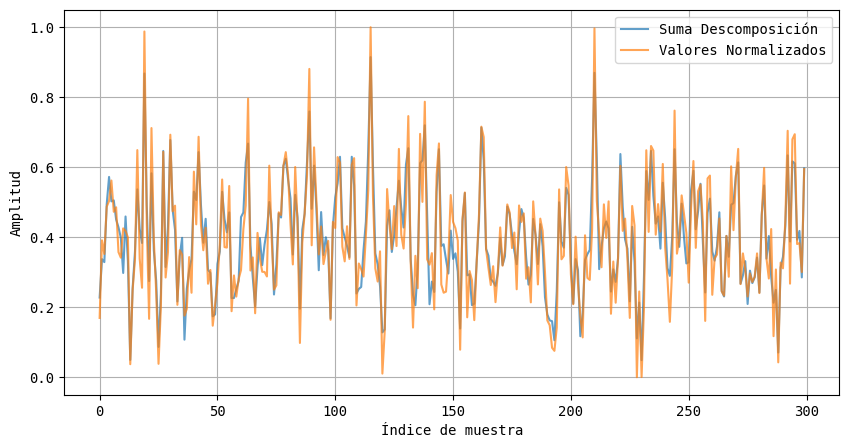

In [26]:
import matplotlib
matplotlib.rcParams['font.family'] = 'monospace'
import matplotlib.pyplot as plt

# Seleccionamos la fila de ejemplo 
row = processing_df.iloc[10]

# Extraemos VMDs e IMFs
vmd_modes = row['VMDs']
imfs = row['IMFs']

# Sumamos desde el segundo hasta el último componente
suma_vmd = np.sum(vmd_modes, axis=0)
suma_ifm = np.sum(imfs[1:], axis=0)
decompose = suma_ifm + suma_vmd

# Recuperamos Valores Normalizados originales
valores_norm = row['ValoresNormalizados']

# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(decompose, label='Suma Descomposición', alpha=0.7)
plt.plot(valores_norm, label='Valores Normalizados', alpha=0.7)
plt.legend()
plt.xlabel('Índice de muestra')
plt.ylabel('Amplitud')
plt.grid(True)

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/realVSdescomposicion.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

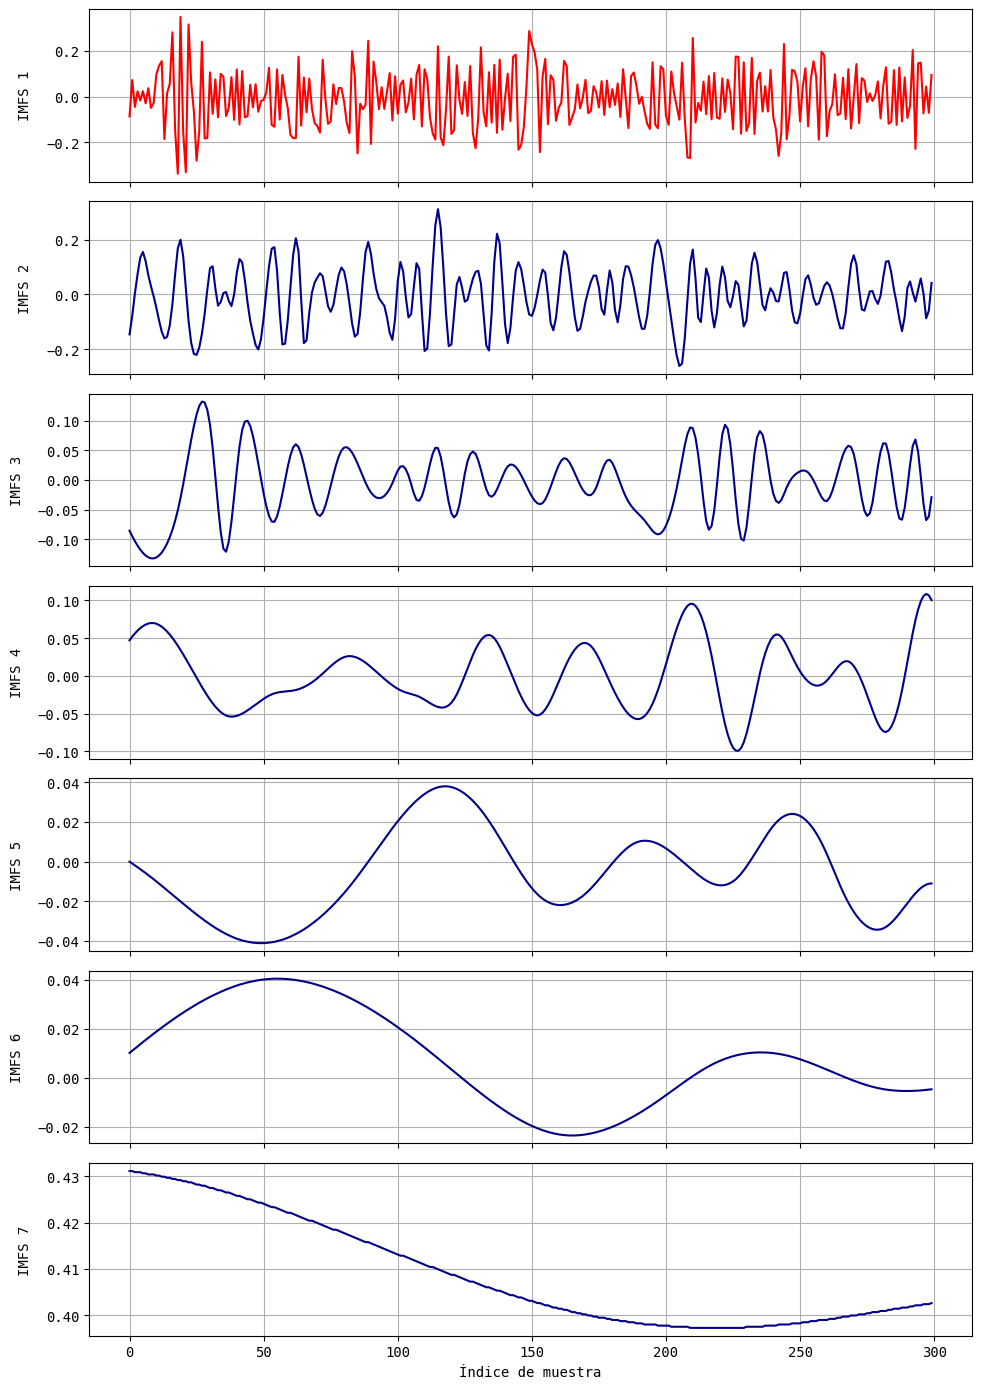

In [27]:
# Crear una figura con subplots
fig, axes = plt.subplots(len(imfs), 1, figsize=(10, 2 * len(imfs)), sharex=True)

# Graficar cada modo, primer modo en rojo y el resto en azul
for i, (mode, ax) in enumerate(zip(imfs, axes), start=1):
    color = 'red' if i == 1 else 'darkblue'
    ax.plot(mode[-500:], color=color)
    ax.set_ylabel(f'IMFS {i}',
                  rotation=90,
                  labelpad=15,
                  va='center')
    ax.grid(True)

# Etiqueta del eje X para el último subplot
axes[-1].set_xlabel('Índice de muestra')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/imfs.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

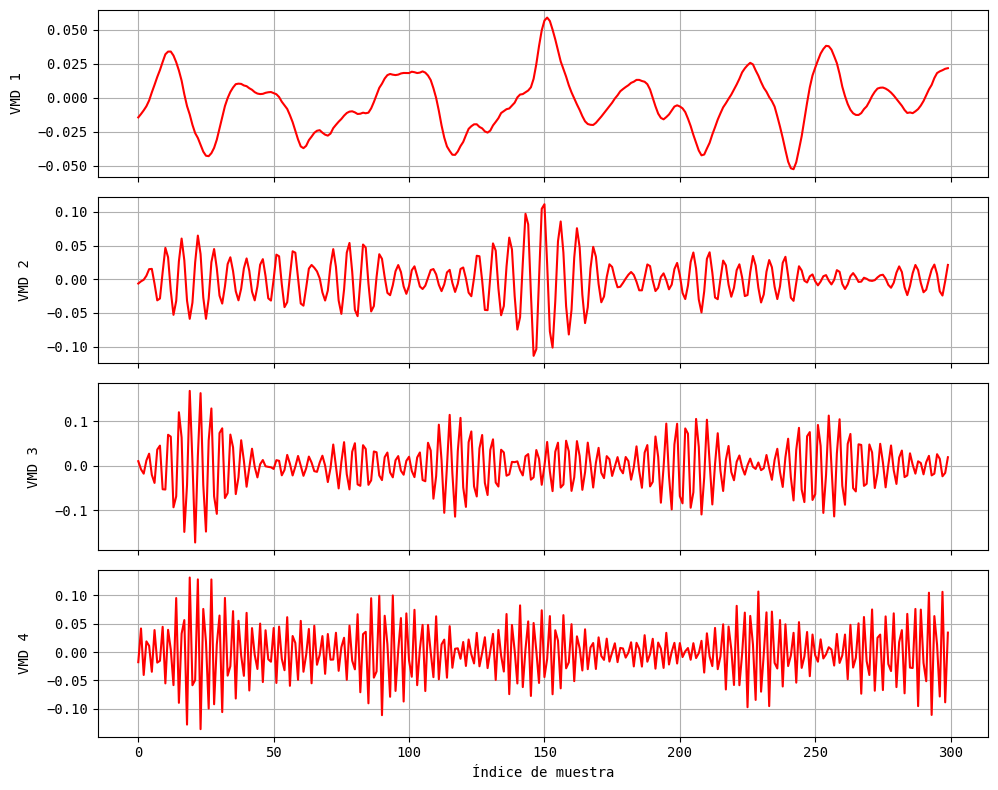

In [28]:
# Crear una figura con subplots
fig, axes = plt.subplots(len(vmd_modes), 1, figsize=(10, 2 * len(vmd_modes)), sharex=True)

# Graficar cada modo en un subplot y usar el eje Y para el título rotado 90°
for i, (mode, ax) in enumerate(zip(vmd_modes, axes), start=1):
    ax.plot(mode[-500:], color='red')
    ax.set_ylabel(f'VMD {i}',
                  rotation=90,
                  labelpad=15,
                  va='center')
    ax.grid(True)

# Etiqueta del eje X para el último subplot
axes[-1].set_xlabel('Índice de muestra')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Guardar la figura
os.makedirs(os.path.join(DATA_FOLDER, "img"), exist_ok=True)
output_file = os.path.join(DATA_FOLDER, "img/vmds.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")